# Assign RegulatoryOverlayUUIDs Values to Water Right sites.csv
Purpose:  To assign RegulatoryOverlayUUIDs values to state water right sites.csv File.

Notes: 
- requires the completed pre-processed sites.csv & watersource.csv files from the state "WaterAllocation/ProcessedInputData" folder to be copied over to the "Regulatory/ProcessedInputData" folder.  Rename to wr_sites.csv & wr_watersource.csv to preserve inputs.
- requires awareness of unique WaterSourceTypeCV of each water right site match up to corresponding WaterSourceTypeCV of regulatoryoverlays per reportingunits

In [1]:
# Needed Libraries / Modules

# ---- working with data ----
import os  # native operating system interaction
import numpy as np  # mathematical array manipulation
import pandas as pd  # data structure and data analysis
import geopandas as gpd  # geo-data structure and data analysis

# ---- visualization ----
import matplotlib.pyplot as plt  # plotting library
import seaborn as sns  # plotting library
import geoplot as gplt # for plotting maps
import geoplot.crs as gcrs #used to pull in webdata

# ---- API data retrieval ----
import requests  # http requests
import json  # JSON parse

# ---- Cleanup ----
import re  # string regular expression manipulation
from datetime import datetime  # date and time manipulation
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook
pd.set_option('display.float_format', lambda x: '%.5f' % x)  # suppress scientific notation in Pandas

In [2]:
# ---- working directory ----
workingDirString = "G:/Shared drives/WaDE Data/Washington/Regulatory/Regulatory_WDNR" # set working directory folder string here
os.chdir(workingDirString)
print(f'The working Directory is:', workingDirString)

The working Directory is: G:/Shared drives/WaDE Data/Washington/Regulatory/Regulatory_WDNR


## Input Data

In [3]:
# Regulatory Input Data
dfro = pd.read_csv("ProcessedInputData/regulatoryoverlays.csv")
dfru = pd.read_csv("ProcessedInputData/reportingunits.csv")
dfrru = pd.read_csv("ProcessedInputData/regulatoryreportingunits.csv")

# Water right Input Data
dfws = pd.read_csv('ProcessedInputData/wr_watersources.csv')
dfs = pd.read_csv('ProcessedInputData/wr_sites.csv', engine = "python", error_bad_lines=False)

C:\Users\rjame\AppData\Local\Temp\ipykernel_4036\447271929.py:8: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dfs = pd.read_csv('ProcessedInputData/wr_sites.csv', engine = "python", error_bad_lines=False)
Skipping line 72641: field larger than field limit (131072)
Skipping line 79095: field larger than field limit (131072)
Skipping line 82677: field larger than field limit (131072)
Skipping line 83717: field larger than field limit (131072)
Skipping line 83718: field larger than field limit (131072)
Skipping line 83719: field larger than field limit (131072)
Skipping line 83720: field larger than field limit (131072)
Skipping line 83721: field larger than field limit (131072)
Skipping line 83722: field larger than field limit (131072)
Skipping line 83723: field larger than field limit (131072)
Skipping line 83724: field larger than field limit (131072)
Skipping line 83725: field larger than 

In [4]:
#### regulatory watersource info with reporting unit info

# merge regulatoryoverlays -to- regulatoryreportingunits -to- reportingunits
dfro = pd.merge(dfro[['RegulatoryOverlayUUID', 'WaterSourceTypeCV']], dfrru[['RegulatoryOverlayUUID', 'ReportingUnitUUID']], left_on='RegulatoryOverlayUUID', right_on='RegulatoryOverlayUUID', how='left')
dfru = pd.merge(dfru, dfro, left_on='ReportingUnitUUID', right_on='ReportingUnitUUID', how='left')

print(dfru['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfru))
dfru.head(1)

['Surface Water']
846


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
0,WDNRre_RUwa1,4326,Chilliwack,wa1,NaN,Watershed Administrative Units,1/7/2021,WA,POLYGON ((-121.23768728399995 49.0007234840000...,WDNRre_RO1,Surface Water


In [5]:
#### water right watersource info with site info

# explode site.csv on WaterSourceUUIDs
dfs = dfs.assign(WaterSourceUUIDs=dfs['WaterSourceUUIDs'].str.split(',')).explode('WaterSourceUUIDs').reset_index(drop=True)

# merge watersources to dfs via WaterSourceUUIDs -to -WaterSourceUUID
dfs = pd.merge(dfs, dfws[['WaterSourceUUID', 'WaterSourceTypeCV']], left_on='WaterSourceUUIDs', right_on='WaterSourceUUID', how='left')
print(dfs['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfs))
dfs.head(1)

['Surface Water' 'WaDE Unspecified' 'Reservoir' 'Groundwater']
129925


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,WAwr_SPOD100002,NaN,WAwr_WSwadeID3,field checked (without GPS),WaDE Unspecified,WaDE Unspecified,4326,NaN,NaN,NaN,NaN,47.65070,-122.21963,NaN,NaN,POD,WaDE Unspecified,POD100002,NaN,Surface Water Pump,WA,NaN,WAwr_WSwadeID3,Surface Water


## Extract RegulatoryOverlay from Reporting Units and assing to WR Sites
- repeat scripts based on the number of ReportingUnitTypeCV types.
- merge all geo-dataframes into one output

#### Regulatory Area Data #1

In [6]:
# Create copy of reportingunits dataframe
# Extract out ReportingUnitTypeCV from reportingunits dataframe
# note unique WaterSourceTypeCV

dfru1 = dfru.copy()
nameOfReportingUnitTypeVar = "Watershed Administrative Units" # change here for ReportingUnitTypeCV of interest
dfru1 = dfru1[dfru1['ReportingUnitTypeCV'] == nameOfReportingUnitTypeVar]
print(len(dfru1))
print(dfru1['WaterSourceTypeCV'].unique())
dfru1.head(1)

846
['Surface Water']


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
0,WDNRre_RUwa1,4326,Chilliwack,wa1,NaN,Watershed Administrative Units,1/7/2021,WA,POLYGON ((-121.23768728399995 49.0007234840000...,WDNRre_RO1,Surface Water


<GeoAxesSubplot: >

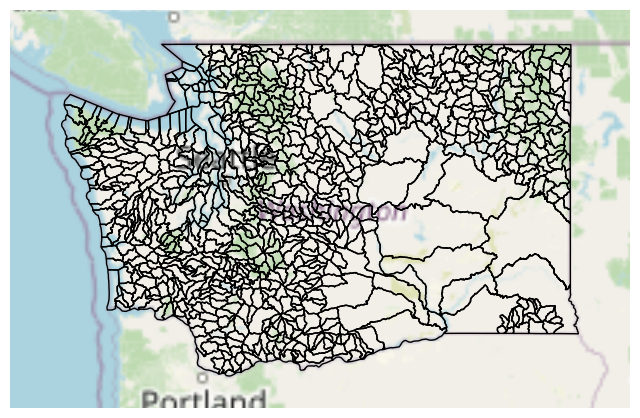

In [7]:
# Convert dataframe -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru1 = dfru1[dfru1['Geometry'] != ""].reset_index(drop=True)
dfru1['Geometry'] = gpd.GeoSeries.from_wkt(dfru1['Geometry'], crs="EPSG:4326")
gdfru1 = gpd.GeoDataFrame(dfru1, geometry=dfru1['Geometry'], crs="EPSG:4326") # covert to geodataframe
gplt.polyplot(gdfru1, ax=ax)

In [8]:
# Create copy of water right sites dataframe
# Extract out WaterSourceTypeCV and match to that of above reportingunits dataframe

dfs1 = dfs.copy()
nameOfWaterSourceTypeCV= "Surface Water" # change here for WaterSourceTypeCV of interest
dfs1 = dfs1[dfs1['WaterSourceTypeCV'] == nameOfWaterSourceTypeCV]
dfs1 = dfs1[dfs1['PODorPOUSite'] == 'POD']
print(len(dfs1))
print(dfs1['WaterSourceTypeCV'].unique())
dfs1.head(1)

26623
['Surface Water']


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,WAwr_SPOD100002,NaN,WAwr_WSwadeID3,field checked (without GPS),WaDE Unspecified,WaDE Unspecified,4326,NaN,NaN,NaN,NaN,47.65070,-122.21963,NaN,NaN,POD,WaDE Unspecified,POD100002,NaN,Surface Water Pump,WA,NaN,WAwr_WSwadeID3,Surface Water


<GeoAxesSubplot: >

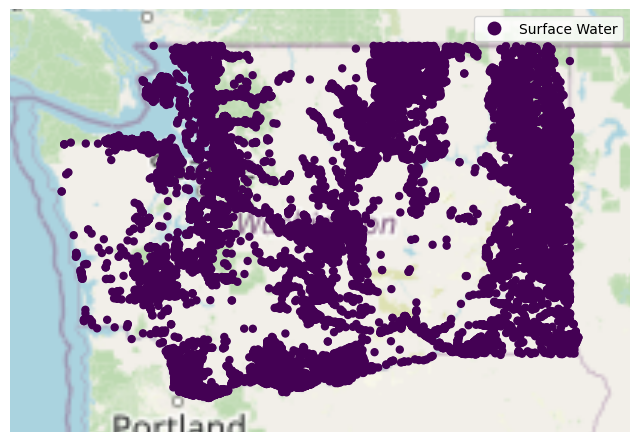

In [9]:
# Convert extracted water right sites -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gdfs1 = gpd.GeoDataFrame(dfs1, geometry=gpd.points_from_xy(dfs1.Longitude.astype(float), dfs1.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs1, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [10]:
# Select sites within polygon.
gdfs1_ru1 = gpd.sjoin(left_df=gdfs1, right_df=gdfru1[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs1_ru1))
gdfs1_ru1.head()

C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


26603


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV,geometry,index_right,ReportingUnitUUID,RegulatoryOverlayUUID
0,WAwr_SPOD100002,,WAwr_WSwadeID3,field checked (without GPS),WaDE Unspecified,WaDE Unspecified,4326,,,,,47.65070,-122.21963,,,POD,WaDE Unspecified,POD100002,,Surface Water Pump,WA,,WAwr_WSwadeID3,Surface Water,POINT (-122.21963 47.65070),64,WDNRre_RUwa157,WDNRre_RO157
2,WAwr_SPOD100006,,WAwr_WSwadeID3,proposed and All-right (does not exist in real...,WaDE Unspecified,WaDE Unspecified,4326,,,,,47.65264,-122.21776,,,POD,WaDE Unspecified,POD100006,,Surface Water Pump,WA,,WAwr_WSwadeID3,Surface Water,POINT (-122.21776 47.65264),64,WDNRre_RUwa157,WDNRre_RO157
3,WAwr_SPOD100008,,WAwr_WSwadeID3,proposed (does not exist in real world),WaDE Unspecified,WaDE Unspecified,4326,,,,,47.65286,-122.21707,,,POD,WaDE Unspecified,POD100008,,Surface Water Pump,WA,,WAwr_WSwadeID3,Surface Water,POINT (-122.21707 47.65286),64,WDNRre_RUwa157,WDNRre_RO157
4,WAwr_SPOD100009,,WAwr_WSwadeID3,proposed (does not exist in real world),WaDE Unspecified,WaDE Unspecified,4326,,,,,47.65170,-122.21327,,,POD,WaDE Unspecified,POD100009,,Surface Water Pump,WA,,WAwr_WSwadeID3,Surface Water,POINT (-122.21327 47.65170),64,WDNRre_RUwa157,WDNRre_RO157
220,WAwr_SPOD100469,,WAwr_WSwadeID3,field checked with GPS,WaDE Unspecified,WaDE Unspecified,4326,,,,,47.65003,-122.22024,,,POD,WaDE Unspecified,POD100469,,Headworks Gravity Flow (or surface water devic...,WA,,WAwr_WSwadeID3,Surface Water,POINT (-122.22024 47.65003),64,WDNRre_RUwa157,WDNRre_RO157


<GeoAxesSubplot: >

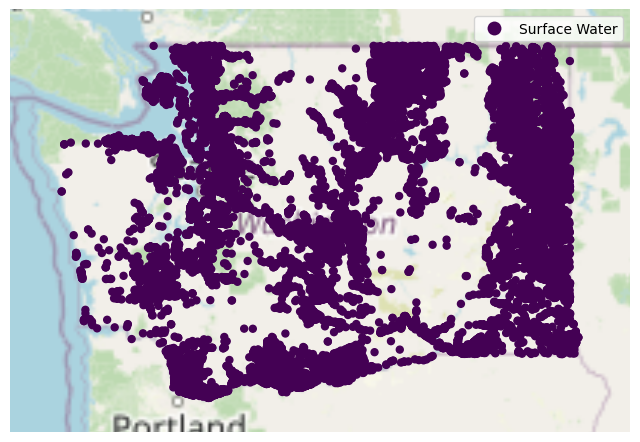

In [11]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gplt.pointplot(gdfs1_ru1, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [12]:
# set RegulatoryOverlayUUIDs
gdfs1_ru1['RegulatoryOverlayUUIDs'] = gdfs1_ru1['RegulatoryOverlayUUID']
gdfs1_ru1 = gdfs1_ru1.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID', 'WaterSourceUUID', 'WaterSourceTypeCV'], axis=1)
gdfs1_ru1.head(1)

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
0,WAwr_SPOD100002,WDNRre_RO157,WAwr_WSwadeID3,field checked (without GPS),WaDE Unspecified,WaDE Unspecified,4326,,,,,47.65070,-122.21963,,,POD,WaDE Unspecified,POD100002,,Surface Water Pump,WA,


#### Regulatory Area Data #2

In [13]:
# dfru2 = dfru.copy()
# etc etc

## Concatenate all Regulatory Area Data Types together
- drop geometry from the wade wr sites.csv geodataframe

In [14]:
# Concatenate dataframes into single output
frames = [dfs, gdfs1_ru1] # list all out dataframes here
outdfs = pd.concat(frames)
outdfs = outdfs.drop_duplicates().reset_index(drop=True).replace(np.nan, "")
outdfs = outdfs.groupby('SiteUUID').agg(lambda x: ','.join([str(elem) for elem in (list(set(x))) if elem != ""])).replace(np.nan, "").reset_index()
print(len(outdfs))
outdfs.head(1)

127740


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,WAwr_SPOD100002,WDNRre_RO157,WAwr_WSwadeID3,field checked (without GPS),WaDE Unspecified,WaDE Unspecified,4326,,,,,47.65069874800008,-122.219626147,,,POD,WaDE Unspecified,POD100002,,Surface Water Pump,WA,,WAwr_WSwadeID3,Surface Water


# Inspect Output Data & Export

In [15]:
outdfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127740 entries, 0 to 127739
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   SiteUUID                127740 non-null  object
 1   RegulatoryOverlayUUIDs  127740 non-null  object
 2   WaterSourceUUIDs        127740 non-null  object
 3   CoordinateAccuracy      127740 non-null  object
 4   CoordinateMethodCV      127740 non-null  object
 5   County                  127740 non-null  object
 6   EPSGCodeCV              127740 non-null  object
 7   Geometry                127740 non-null  object
 8   GNISCodeCV              127740 non-null  object
 9   HUC12                   127740 non-null  object
 10  HUC8                    127740 non-null  object
 11  Latitude                127740 non-null  object
 12  Longitude               127740 non-null  object
 13  NHDNetworkStatusCV      127740 non-null  object
 14  NHDProductCV            127740 non-n

In [16]:
outdfs

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,WAwr_SPOD100002,WDNRre_RO157,WAwr_WSwadeID3,field checked (without GPS),WaDE Unspecified,WaDE Unspecified,4326,,,,,47.65069874800008,-122.219626147,,,POD,WaDE Unspecified,POD100002,,Surface Water Pump,WA,,WAwr_WSwadeID3,Surface Water
1,WAwr_SPOD100004,WDNRre_RO39,WAwr_WSwadeID3,unchecked and Dubious,WaDE Unspecified,WaDE Unspecified,4326,,,,,48.53634364700008,-122.88346013399996,,,POD,WaDE Unspecified,POD100004,,Headworks Gravity Flow (or surface water devic...,WA,,WAwr_WSwadeID3,Surface Water
2,WAwr_SPOD100006,WDNRre_RO157,WAwr_WSwadeID3,proposed and All-right (does not exist in real...,WaDE Unspecified,WaDE Unspecified,4326,,,,,47.652644743000046,-122.217763301,,,POD,WaDE Unspecified,POD100006,,Surface Water Pump,WA,,WAwr_WSwadeID3,Surface Water
3,WAwr_SPOD100008,WDNRre_RO157,WAwr_WSwadeID3,proposed (does not exist in real world),WaDE Unspecified,WaDE Unspecified,4326,,,,,47.65286443600007,-122.21706725099996,,,POD,WaDE Unspecified,POD100008,,Surface Water Pump,WA,,WAwr_WSwadeID3,Surface Water
4,WAwr_SPOD100009,WDNRre_RO157,WAwr_WSwadeID3,proposed (does not exist in real world),WaDE Unspecified,WaDE Unspecified,4326,,,,,47.65170126000004,-122.21327070299996,,,POD,WaDE Unspecified,POD100009,,Surface Water Pump,WA,,WAwr_WSwadeID3,Surface Water
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127735,WAwr_SPOUwade197345,,WAwr_WSwadeID3,WaDE Unspecified,WaDE Unspecified,WaDE Unspecified,4326,POLYGON ((-119.49631283926607 46.8303052419933...,,,,46.8332754851,-119.495280493,,,POU,WaDE Unspecified,POUwade197345,,WaDE Unspecified,WA,,WAwr_WSwadeID3,Surface Water
127736,WAwr_SPOUwade197346,,WAwr_WSwadeID3,WaDE Unspecified,WaDE Unspecified,WaDE Unspecified,4326,POLYGON ((-119.53824714169218 46.8391017483470...,,,,46.8356288945,-119.52737127,,,POU,WaDE Unspecified,POUwade197346,,WaDE Unspecified,WA,,WAwr_WSwadeID3,Surface Water
127737,WAwr_SPOUwade197347,,WAwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,WaDE Unspecified,4326,POLYGON ((-118.97255834738979 46.3802638677833...,,,,46.3835247155,-118.961894802,,,POU,WaDE Unspecified,POUwade197347,,WaDE Unspecified,WA,,WAwr_WSwadeID2,Groundwater
127738,WAwr_SPOUwade197348,,WAwr_WSwadeID2,WaDE Unspecified,WaDE Unspecified,WaDE Unspecified,4326,POLYGON ((-118.95208922363872 46.3579778607896...,,,,46.361692718,-118.957282568,,,POU,WaDE Unspecified,POUwade197348,,WaDE Unspecified,WA,,WAwr_WSwadeID2,Groundwater


In [17]:
# Export out to CSV.
outdfs.to_csv('ProcessedInputData/sites.csv', index=False) # this is in the Regulatory data folder